# Analysis of Ride Demands from Ford Gobike 2019 Data
## by Meng Tan

## Investigation Overview

In this investigation, I wanted to figure out what variables can influence the ride demands in San Francisco Bay area. The main focus was on the following variables: duration time, user type, time of a day, day of a week, months, station longitude and latitude.

## Dataset Overview

This dataset containing the whole year (2019) information about approximately 2,506,983 individual rides made in a bike-sharing system in the greater San Francisco Bay area. The information included ride duration time, ride start time, end time, user type, start station longitude and latitude, end station longitude and latitude, and some other attributes. I collected these 12 months' data from [LWFT Website](https://www.lyft.com/bikes/bay-wheels). Since some months' datasets did not include columns `bike_share_for_all_trip` and `rental_access_method`, I decided to remove these two columns from other months and combined all months into a whole year data. After cleaning process, I removed one outlier for an impossible duration time and 103 observations for test purpose.

In [48]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [49]:
# load in the dataset into a pandas dataframe
df = pd.read_pickle('fordgobike_2019_clean.pkl')

In [50]:
# Remove outliers
duration_outlier = df['duration_min']>2000
df = df.loc[-duration_outlier, :].reset_index(drop=True)

coord_outliers = (df['start_station_latitude'] < 36) | (df['start_station_latitude'] > 39) | (df['start_station_longitude'] > -120) | (df['end_station_latitude'] < 36) | (df['end_station_latitude'] > 39) | (df['end_station_longitude'] > -120)
df = df.loc[-coord_outliers, :].reset_index(drop=True)

## Distribution of Duration Time Per Ride

The duration time follows a right-skewed distribution, so I decided to apply log transformation on this variable. The plot with logarithmic scale shows a roughly normal shape.

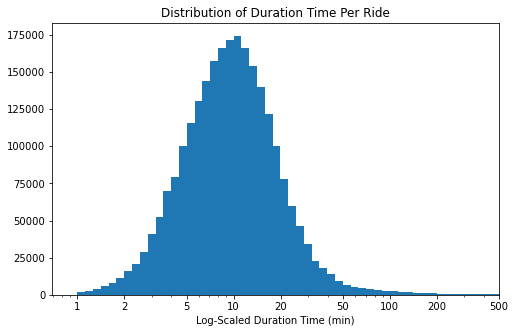

In [51]:
log_binsize = 0.05
bins = 10 ** np.arange(0, 3.16+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data=df, x='duration_min', bins=bins)
plt.xscale('log')
x_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
plt.xticks(x_ticks, x_ticks)
plt.xlim(right=500)
plt.xlabel('Log-Scaled Duration Time (min)')
plt.title('Distribution of Duration Time Per Ride');

## Distribution of Latitude and Distribution of  Longitude

Interestingly, it seems that rides happened in several geologically separate areas.

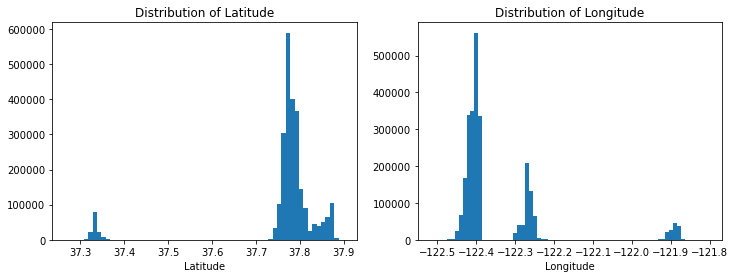

In [52]:

binsize=0.01
bins_lat = np.arange(df.start_station_latitude.min(), df.start_station_latitude.max()+binsize, binsize)
bins_lon = np.arange(df.start_station_longitude.min(), df.start_station_longitude.max()+binsize, binsize)
    
fig, ax = plt.subplots(ncols=2, figsize=[12, 4])
ax[0].hist(data=df, x='start_station_latitude', bins=bins_lat)
ax[0].set_xlabel('Latitude')
ax[0].set_title('Distribution of Latitude')

ax[1].hist(data=df, x='start_station_longitude', bins=bins_lon)
ax[1].set_xlabel('Longitude')
ax[1].set_title('Distribution of Longitude');

## Longitude vs. Duration Time Per Ride in Log-scale
There are some differences of ride demands among three regions:
- From left to right, the leftmost area sees the most traffic and the more longer trips(>200min).
- The rightmost area sees clearly more shorter trips(<150min).

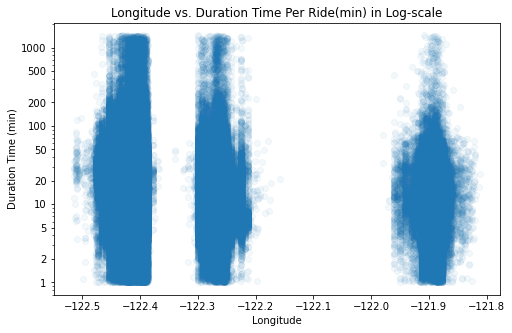

In [53]:
plt.figure(figsize=[8,5])
plt.scatter(data=df, x='start_station_longitude', y='duration_min', alpha=1/20)
plt.yscale('log')
y_ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
plt.yticks(y_ticks, y_ticks)
plt.ylabel('Duration Time (min)')
plt.xlabel('Longitude')
plt.title('Longitude vs. Duration Time Per Ride(min) in Log-scale');

## User Types vs. Three Categorical Time Features

In [54]:
def count_plot(data, x, hue='user_type', **kwargs):
    sns.countplot(data=data, x=x, hue=hue);

**User types vs. Months**:
- For subscribers, March and July are busiest months, while December has fewest rides, which perhaps is due to the cold weather or Christmas holiday.
- For customers, surprisingly, even though December is cold, it is the busiest month, which is the opposite of the subscriber's.

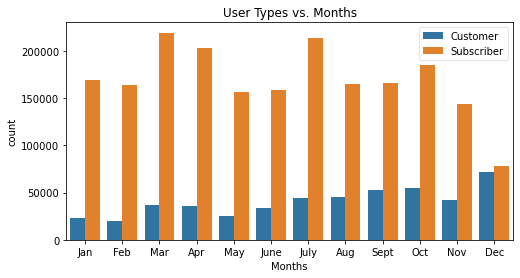

In [55]:

plt.figure(figsize=[8, 4])

count_plot(data=df, x='start_month')
plt.legend(framealpha=0.5)
plt.xlabel('Months')
plt.title('User Types vs. Months');

**User Types vs. Days of Week**:
- For subscribers, working days see a nearly or more than double rides of weekends, which may suggest at least half of subscribers need to ride to work or study.
- For customers, which days of week have little influence on the ride demands, since there's little difference of trips count from Monday to Sunday.

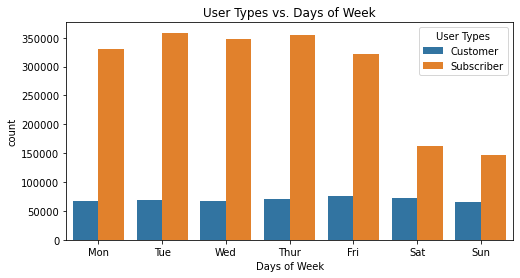

In [56]:
plt.figure(figsize=[8, 4])
count_plot(data=df, x='start_weekday')
plt.xlabel('Days of Week')
plt.title('User Types vs. Days of Week')
plt.legend(title='User Types');

**User Types vs. Time of Day**:
- For subscribers, as expected, rush hours(8am and 5pm) see the highest ride demands, which suggests again that subscribers need to ride to commute.
- For customers, it also shows a roughly bimodal distribution, but it is less clear when compared to subscriber's distribution.

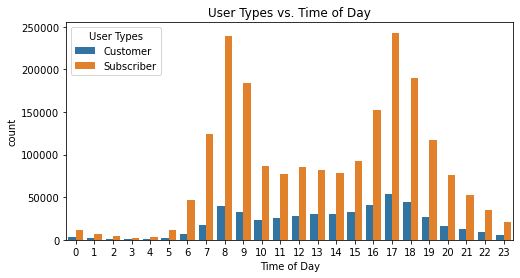

In [57]:
plt.figure(figsize=[8, 4])
count_plot(data=df, x='start_hour')
plt.xlabel('Time of Day')
plt.title('User Types vs. Time of Day')
plt.legend(title='User Types', loc=2);

## Scatter Plot of Rides by Longitude and Latitude for User Types

In [58]:
df_a = df.loc[df['start_station_longitude'] <= -122.35].reset_index(drop=True)
df_b = df.loc[(df['start_station_longitude'] > -122.35) & (df['start_station_longitude'] < -122.15)].reset_index(drop=True)
df_c = df.loc[df['start_station_longitude'] >= -122.15].reset_index(drop=True)

Subscribers dominated the A, B area and the center of C area:
- Area A has the busiest traffic, and most rides happened in the Northeast area. Then for the northern part, the traffic gradually decreased from east to west; for the southern part, the traffic decreased from north to south. More customers (blue points) are seen in the northwest part.
- Area B has the most compact traffic, less sparse when compared to A and C.
- Area C has the most sparse traffic, which maybe due to the least traffic in this area (this information gained from Bivariate Exploration part). More subscribers are seen in the central part, while more customers ride in the periphery of area C.

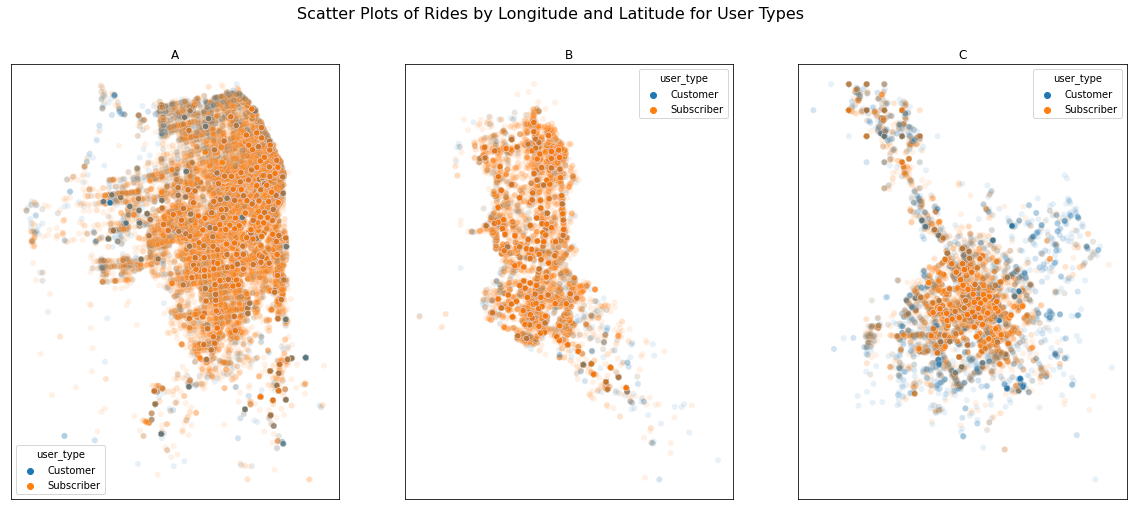

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[20, 8])

sns.scatterplot(data=df_a, y='start_station_latitude', x='start_station_longitude', 
                hue='user_type', alpha=1/10, x_jitter=0.01, ax=ax[0])
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('A')
sns.scatterplot(data=df_b, y='start_station_latitude', x='start_station_longitude', 
                hue='user_type', alpha=1/10, x_jitter=0.01, ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('B')
sns.scatterplot(data=df_c, y='start_station_latitude', x='start_station_longitude', 
                hue='user_type', alpha=1/10, x_jitter=0.01, ax=ax[2])
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[2].set_title('C')

plt.suptitle('Scatter Plots of Rides by Longitude and Latitude for User Types', fontsize=16);

## Rides For Customers and Subscribers In Three Regions Through Months

**There are dramatic shifts from month to month for those three regions:**

- For A and C, there is an expanding tendency from January to July, especially for C, the tendency is more clear than A. 
- For B, July has a sharp expanding from June. 
- After the most spreading status of July, there's a sudden shrinking status for all three regions and it seems that it comes back to the same status of May. 
- The expanding tendency starts again from October for A and C, and December has another peak of spreading. For B, there's no spreading at all, but it seems relatively more customers choose to ride than subscribers.

In [60]:
def scatter_plot(x, y, hue, **kwargs):
    ax = sns.scatterplot(x=x, y=y, hue=hue, alpha=1/5, x_jitter=0.01)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def facet_scatter(data, title, col='start_month', col_wrap=6, height=3, legend_out=True):
    g = sns.FacetGrid(data=data, col=col, col_wrap=col_wrap, height=height, legend_out=legend_out)
    g.map(scatter_plot, 'start_station_longitude', 'start_station_latitude', 'user_type')
    g.set_titles(col_template='{col_name}')
    g.add_legend();
    plt.suptitle(title, fontsize=16)
    g.tight_layout();

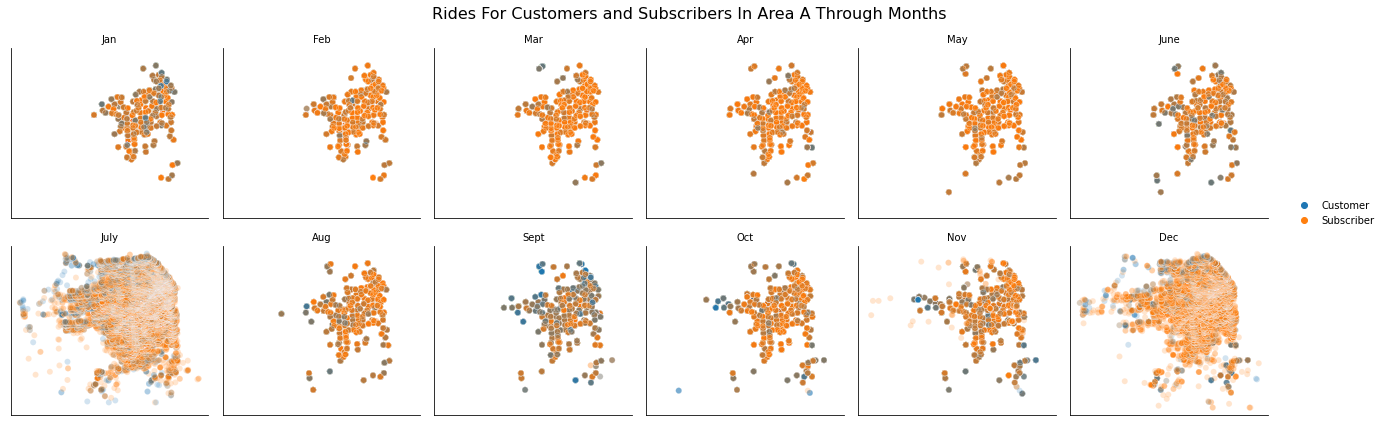

In [61]:
facet_scatter(data=df_a, title='Rides For Customers and Subscribers In Area A Through Months')

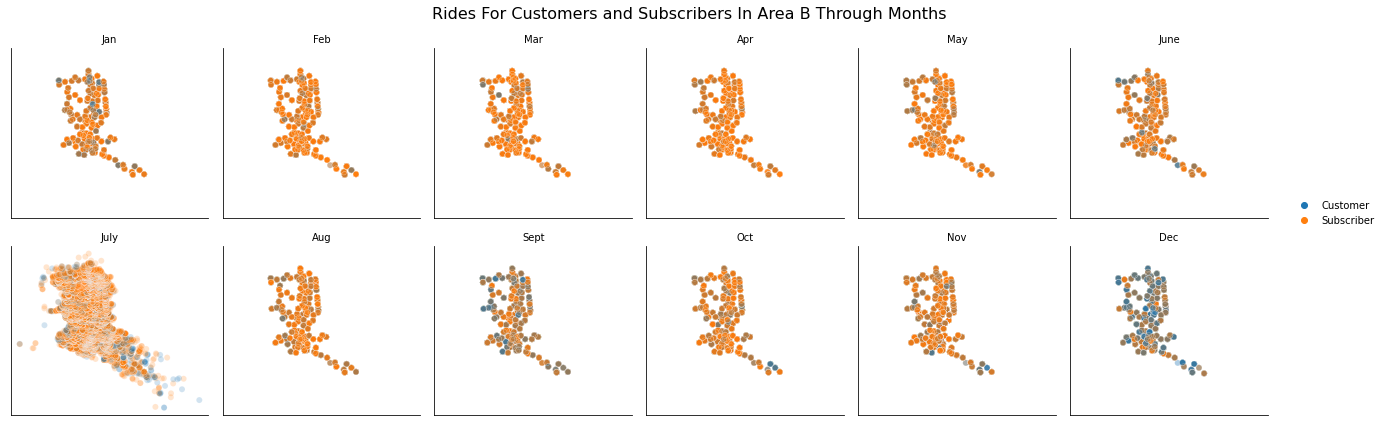

In [62]:
facet_scatter(data=df_b, title='Rides For Customers and Subscribers In Area B Through Months')

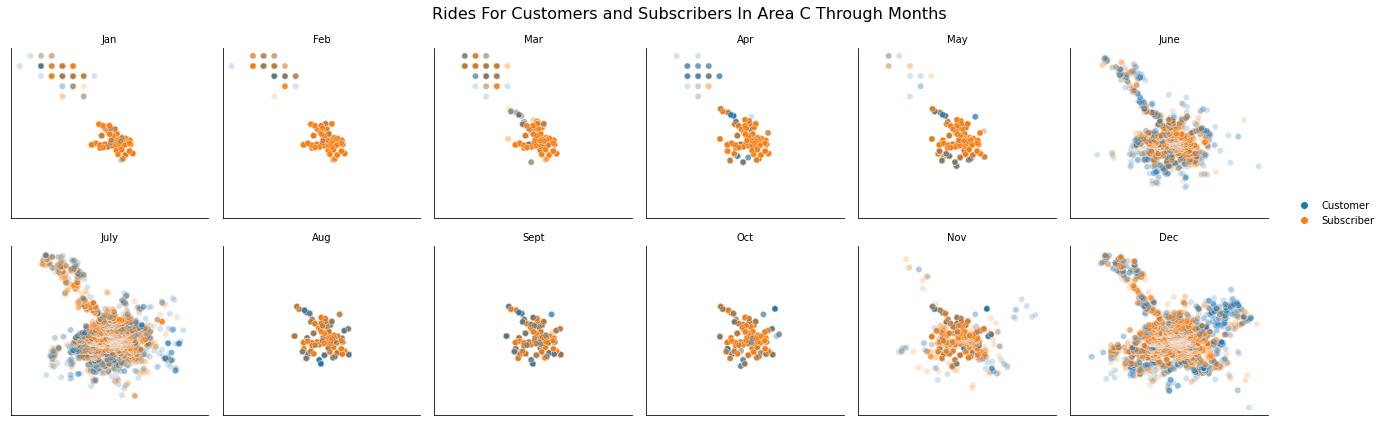

In [63]:
facet_scatter(data=df_c, title='Rides For Customers and Subscribers In Area C Through Months')

## Duration Time Per Ride for User Types in Three Time Features

**For duration time per ride, customers always tend to ride longer than subscribers:**

- Time of a day for both, more fluctuations happened during 1:00-5:00. Then for subscribers, they tend to ride for 10 minutes; for customers, during rush hours they tend to ride 15 to 20 minutes, other hours more than 20 minutes.
- Day of a week for both, longer rides happened on weedends compared to working days. And the increasing percentage for customers is higher than that for subscribers.
- Through months, the riding duration time is generally decreasing for customers, and the most drastic decrease happened in December; there are some relatively some fluctuations for subscribers, and most of them tend to ride a little longer for July.

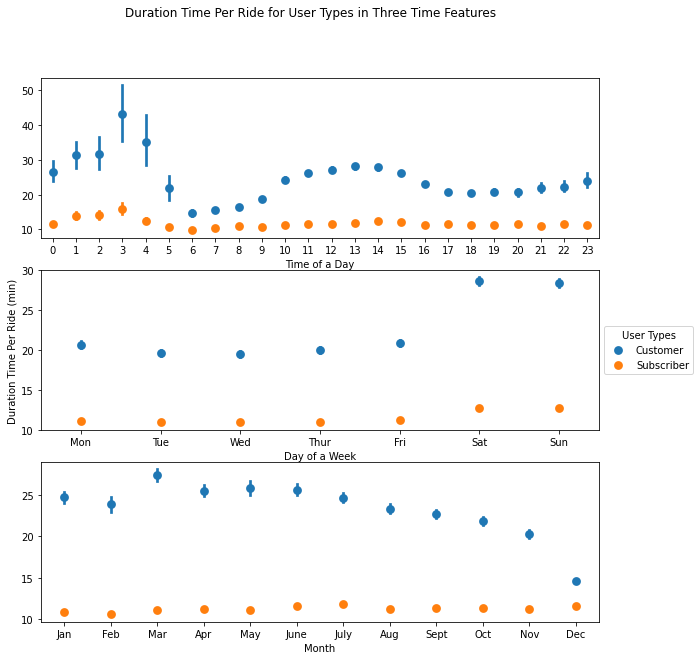

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=[10, 10])

sns.pointplot(data=df, x='start_hour', y='duration_min', hue='user_type', linestyles='', ax=ax[0])
ax[0].set_xlabel('Time of a Day')
ax[0].set_ylabel('')
ax[0].get_legend().remove()

sns.pointplot(data=df, x='start_weekday', y='duration_min', hue='user_type', linestyles='', ax=ax[1])
ax[1].set_xlabel('Day of a Week')
ax[1].set_ylabel('Duration Time Per Ride (min)')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='User Types')

sns.pointplot(data=df, x='start_month', y='duration_min', hue='user_type', linestyles='', ax=ax[2])
ax[2].set_xlabel('Month')
ax[2].set_ylabel('')
ax[2].get_legend().remove()
plt.suptitle('Duration Time Per Ride for User Types in Three Time Features');

## Duration Time Per Ride for Hour and Day of Week

**Duration tendency related to time of a day and day of a week:**

- Before 7:00, there is larger uncertainty of ride minutes for both weekdays and weekends. 
- After 20:00, the duration time are similar for weekdays and weekends. 
- From 6:00 to 18:00, there's a big gap for weekdays and weekends.
- In general, the duration time change tendency for weekdays and weekends are similar, except the change for weekends is shaper than weekdays.

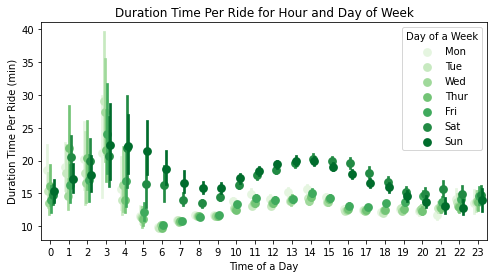

In [65]:
plt.figure(figsize=[8, 4])
sns.pointplot(data=df, x='start_hour', y='duration_min', hue='start_weekday', 
              palette='Greens', linestyles='', dodge=0.4)
plt.xlabel('Time of a Day')
plt.ylabel('Duration Time Per Ride (min)')
plt.legend(title='Day of a Week')
plt.title('Duration Time Per Ride for Hour and Day of Week');

## Total Duration Time for Geological Coordinates

For the whole 2019, the northeast of area A achieved the highest bike duration time among total three areas, and some blocks of area A even saw a total riding time more than five million minutes. For area B and C, the riding time distributed evenly through blocks, except a little busier in central parts. 

In [66]:
lat_min = df.start_station_latitude.min()
lat_max = df.start_station_latitude.max()
lon_min = df.start_station_longitude.min()
lon_max = df.start_station_longitude.max()

binsize=0.02
bins_y = np.arange(lat_min, lat_max+binsize, binsize)
bins_x = np.arange(lon_min, lon_max+binsize, binsize)

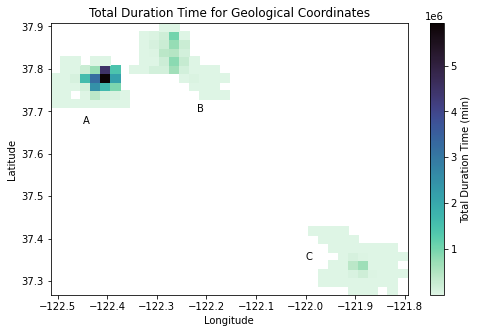

In [67]:
plt.figure(figsize=[8,5])
plt.hist2d(data=df, x='start_station_longitude', y='start_station_latitude', bins=[bins_x, bins_y], 
           weights='duration_min', cmap='mako_r',cmin=0.5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.colorbar().set_label('Total Duration Time (min)')
plt.title('Total Duration Time for Geological Coordinates')
plt.text(-122, 37.35, 'C')
plt.text(-122.22, 37.7, 'B')
plt.text(-122.45, 37.67, 'A');

## Total Duration Time for Hour and Day of a Week

- From Monday to Friday, the total duration time for each hour is more than 0.6m minutes around 8:00 and 17:00; when it is not rush hours, 0:00-6:00 is a time range with fewest duration minutes, while 10:00-15:00 produces more ride minutes than 20:00-23:00. 
- For weekends, the situation changes completely. They only show one peak through a whole day, which is round 11:00-16:00.
- In general, weekdays achieved more duration time than weekends, and there are total different peak periods between weekdays and weekends.

In [68]:
hour_week_min = df.pivot_table(index='start_hour', columns='start_weekday',  values='duration_min', aggfunc=sum)

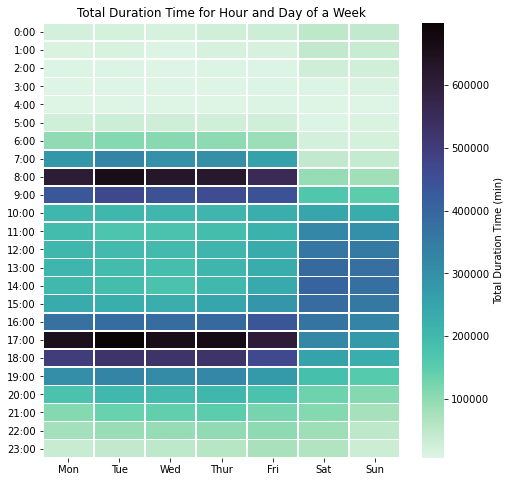

In [69]:
plt.figure(figsize=[8,8])
g = sns.heatmap(hour_week_min, cmap='mako_r', linewidths=.5, 
            cbar_kws={'label': 'Total Duration Time (min)'})
hour_loc = np.arange(0.5, 24.5).tolist()
hour_ticks = ['{}:00'.format(i) for i in range(24)] 
plt.yticks(hour_loc, hour_ticks, rotation=0)
plt.xlabel('')
plt.ylabel('')
plt.title('Total Duration Time for Hour and Day of a Week');

**Due to the information we gained from previous work, I think user types probably play some role for this difference.**

## Total Duration Time for Hour and Day of a Week with User Types

As expected, customers contribute relatively more to the weekends compared to weekdays, while subscribers contribute inversely. Moreover, the boundary line between weekdays and weekends is more clear for subscribers than for customers, since customers also ride some minutes around 17:00 during weekdays. 

In [70]:
df_customer = df.loc[df['user_type'] == 'Customer'].reset_index(drop=True)
df_subscriber = df.loc[df['user_type'] == 'Subscriber'].reset_index(drop=True)

hwm_cus = df_customer.pivot_table(index='start_hour', columns='start_weekday',  values='duration_min', aggfunc=sum)
hwm_sub = df_subscriber.pivot_table(index='start_hour', columns='start_weekday',  values='duration_min', aggfunc=sum)

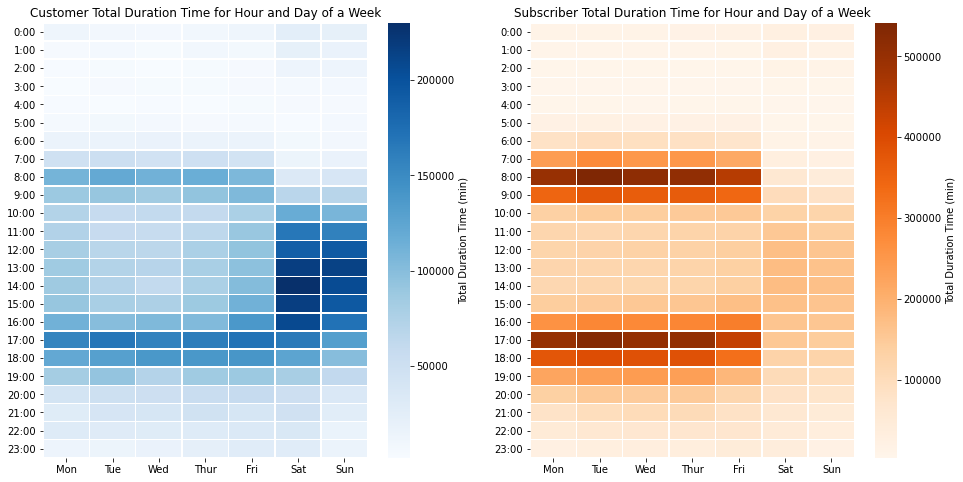

In [71]:
plt.figure(figsize=[16,8])

plt.subplot(1, 2, 1)
sns.heatmap(hwm_cus, cmap='Blues', linewidths=.5, 
            cbar_kws={'label': 'Total Duration Time (min)'})
hour_loc = np.arange(0.5, 24.5).tolist()
hour_ticks = ['{}:00'.format(i) for i in range(24)] 
plt.yticks(hour_loc, hour_ticks, rotation=0)
plt.xlabel('')
plt.ylabel('')
plt.title('Customer Total Duration Time for Hour and Day of a Week');

plt.subplot(1, 2, 2)
sns.heatmap(hwm_sub, cmap='Oranges', linewidths=.5, 
            cbar_kws={'label': 'Total Duration Time (min)'})
hour_loc = np.arange(0.5, 24.5).tolist()
hour_ticks = ['{}:00'.format(i) for i in range(24)] 
plt.yticks(hour_loc, hour_ticks, rotation=0)
plt.xlabel('')
plt.ylabel('')
plt.title('Subscriber Total Duration Time for Hour and Day of a Week');